# Preprocessing
## General stuff
*(Loading data, prepare for future working)*

In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [3]:
# ############LOADING BASEDATASET #########################

data_folder = "../data"
dataset = "credit_train"
file_type = ".csv"
df = pd.read_csv(data_folder+"/"+dataset+file_type)

In [4]:
# removing unwanted features like LOanID and CustomerID
df = df.drop(df[['Loan ID', 'Customer ID']], axis=1)

In [5]:
# Drop record if it does not have at least 'n' values that are **not** NaN out of 17 columns
# finding val of 'n', we will see how many records are dropped at each threshlod val
threshold = 0

for i in range(1, 18):
    mod_df = df.dropna(thresh=i)
    total_rows = mod_df.shape[0]
    if total_rows < 1: 
        break
    else: 
        threshold = i
        
threshold

17

In [6]:
# remove NAN values from the dataframe
df = df.dropna(thresh=threshold)

In [7]:
# Convert Loan Status to 0 or 1
df['Loan Status'] = [0 if x == 'Fully Paid' else 1 for x in  df['Loan Status']]

In [8]:
# encode features
label_encoder = preprocessing.LabelEncoder()
df['Loan Status'] = df['Loan Status'].astype(np.str)
df['Loan Status'] = label_encoder.fit_transform(df['Loan Status']).astype(np.float64)

label_encoder1 = preprocessing.LabelEncoder()
df['Term'] = label_encoder1.fit_transform(df['Term']).astype(np.float64)

encoder = preprocessing.OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(df[['Home Ownership', 'Purpose']]).toarray(),
                       columns=encoder.get_feature_names(['Home Ownership', 'Purpose']))
encoded.info()
#df = df.drop(df[['Home Ownership', 'Purpose']], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36423 entries, 0 to 36422
Data columns (total 20 columns):
Home Ownership_HaveMortgage     36423 non-null float64
Home Ownership_Home Mortgage    36423 non-null float64
Home Ownership_Own Home         36423 non-null float64
Home Ownership_Rent             36423 non-null float64
Purpose_Business Loan           36423 non-null float64
Purpose_Buy House               36423 non-null float64
Purpose_Buy a Car               36423 non-null float64
Purpose_Debt Consolidation      36423 non-null float64
Purpose_Educational Expenses    36423 non-null float64
Purpose_Home Improvements       36423 non-null float64
Purpose_Medical Bills           36423 non-null float64
Purpose_Other                   36423 non-null float64
Purpose_Take a Trip             36423 non-null float64
Purpose_major_purchase          36423 non-null float64
Purpose_moving                  36423 non-null float64
Purpose_other                   36423 non-null float64
Purpose_ren

In [9]:
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", "../functions.py")
functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(functions)

In [10]:
# Apply functions
df['Years in current job'] = df['Years in current job'].apply(functions.f).astype(np.float64)
df['Credit Score'] = df['Credit Score'].apply(functions.cs)

# #fill NaN values groupby more related column
df['Credit Score'].fillna(value=df.groupby('Home Ownership')['Credit Score'].transform('median'), inplace=True)
df['Annual Income'].fillna(value=df.groupby('Purpose')['Annual Income'].transform('median'), inplace=True)
df['Years in current job'].fillna(value=df.groupby('Home Ownership')['Years in current job'].transform('median'),
                                  inplace=True)
df['Months since last delinquent'].fillna(0, inplace=True)
df['Maximum Open Credit'].fillna(value=df.groupby('Home Ownership')['Maximum Open Credit'].transform('median'),
                                 inplace=True)
df['Bankruptcies'].fillna(0, inplace=True)
df['Tax Liens'].fillna(0, inplace=True)

df["Monthly Income"] = df.apply(lambda row: functions.mi(row), axis=1)
df["Credit Ration per Year"]= df.apply(lambda row: functions.cr(row), axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36423 entries, 2 to 99997
Data columns (total 19 columns):
Loan Status                     36423 non-null float64
Current Loan Amount             36423 non-null float64
Term                            36423 non-null float64
Credit Score                    36423 non-null float64
Annual Income                   36423 non-null float64
Years in current job            36423 non-null float64
Home Ownership                  36423 non-null object
Purpose                         36423 non-null object
Monthly Debt                    36423 non-null float64
Years of Credit History         36423 non-null float64
Months since last delinquent    36423 non-null float64
Number of Open Accounts         36423 non-null float64
Number of Credit Problems       36423 non-null float64
Current Credit Balance          36423 non-null float64
Maximum Open Credit             36423 non-null float64
Bankruptcies                    36423 non-null float64
Tax Liens    

In [11]:
# merging categorical encoded dataframe with the main dataframe and deleting unwanted features
df = df.reset_index(drop=True).merge(encoded.reset_index(drop=True), left_index=True, right_index=True)
# remove it from the dataframe so it only contains the features that our model should use
df = df.drop(df[['Home Ownership', 'Purpose']], axis=1)
df.head(10)

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,...,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,0.0,99999999.0,1.0,741.0,2231892.0,8.0,29200.53,14.9,29.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,217646.0,1.0,730.0,1184194.0,0.0,10855.08,19.6,10.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,548746.0,1.0,678.0,2559110.0,2.0,18660.28,22.6,33.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,99999999.0,1.0,728.0,714628.0,3.0,11851.06,16.0,76.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,99999999.0,1.0,740.0,776188.0,0.0,11578.22,8.5,25.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,234124.0,1.0,727.0,693234.0,10.0,14211.24,24.7,46.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,666204.0,0.0,723.0,1821967.0,10.0,17612.24,22.0,34.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,317108.0,0.0,687.0,1133274.0,8.0,9632.81,17.4,53.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,465410.0,0.0,688.0,1722654.0,3.0,15647.45,22.3,30.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,99999999.0,1.0,746.0,1749748.0,10.0,19247.19,20.0,32.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


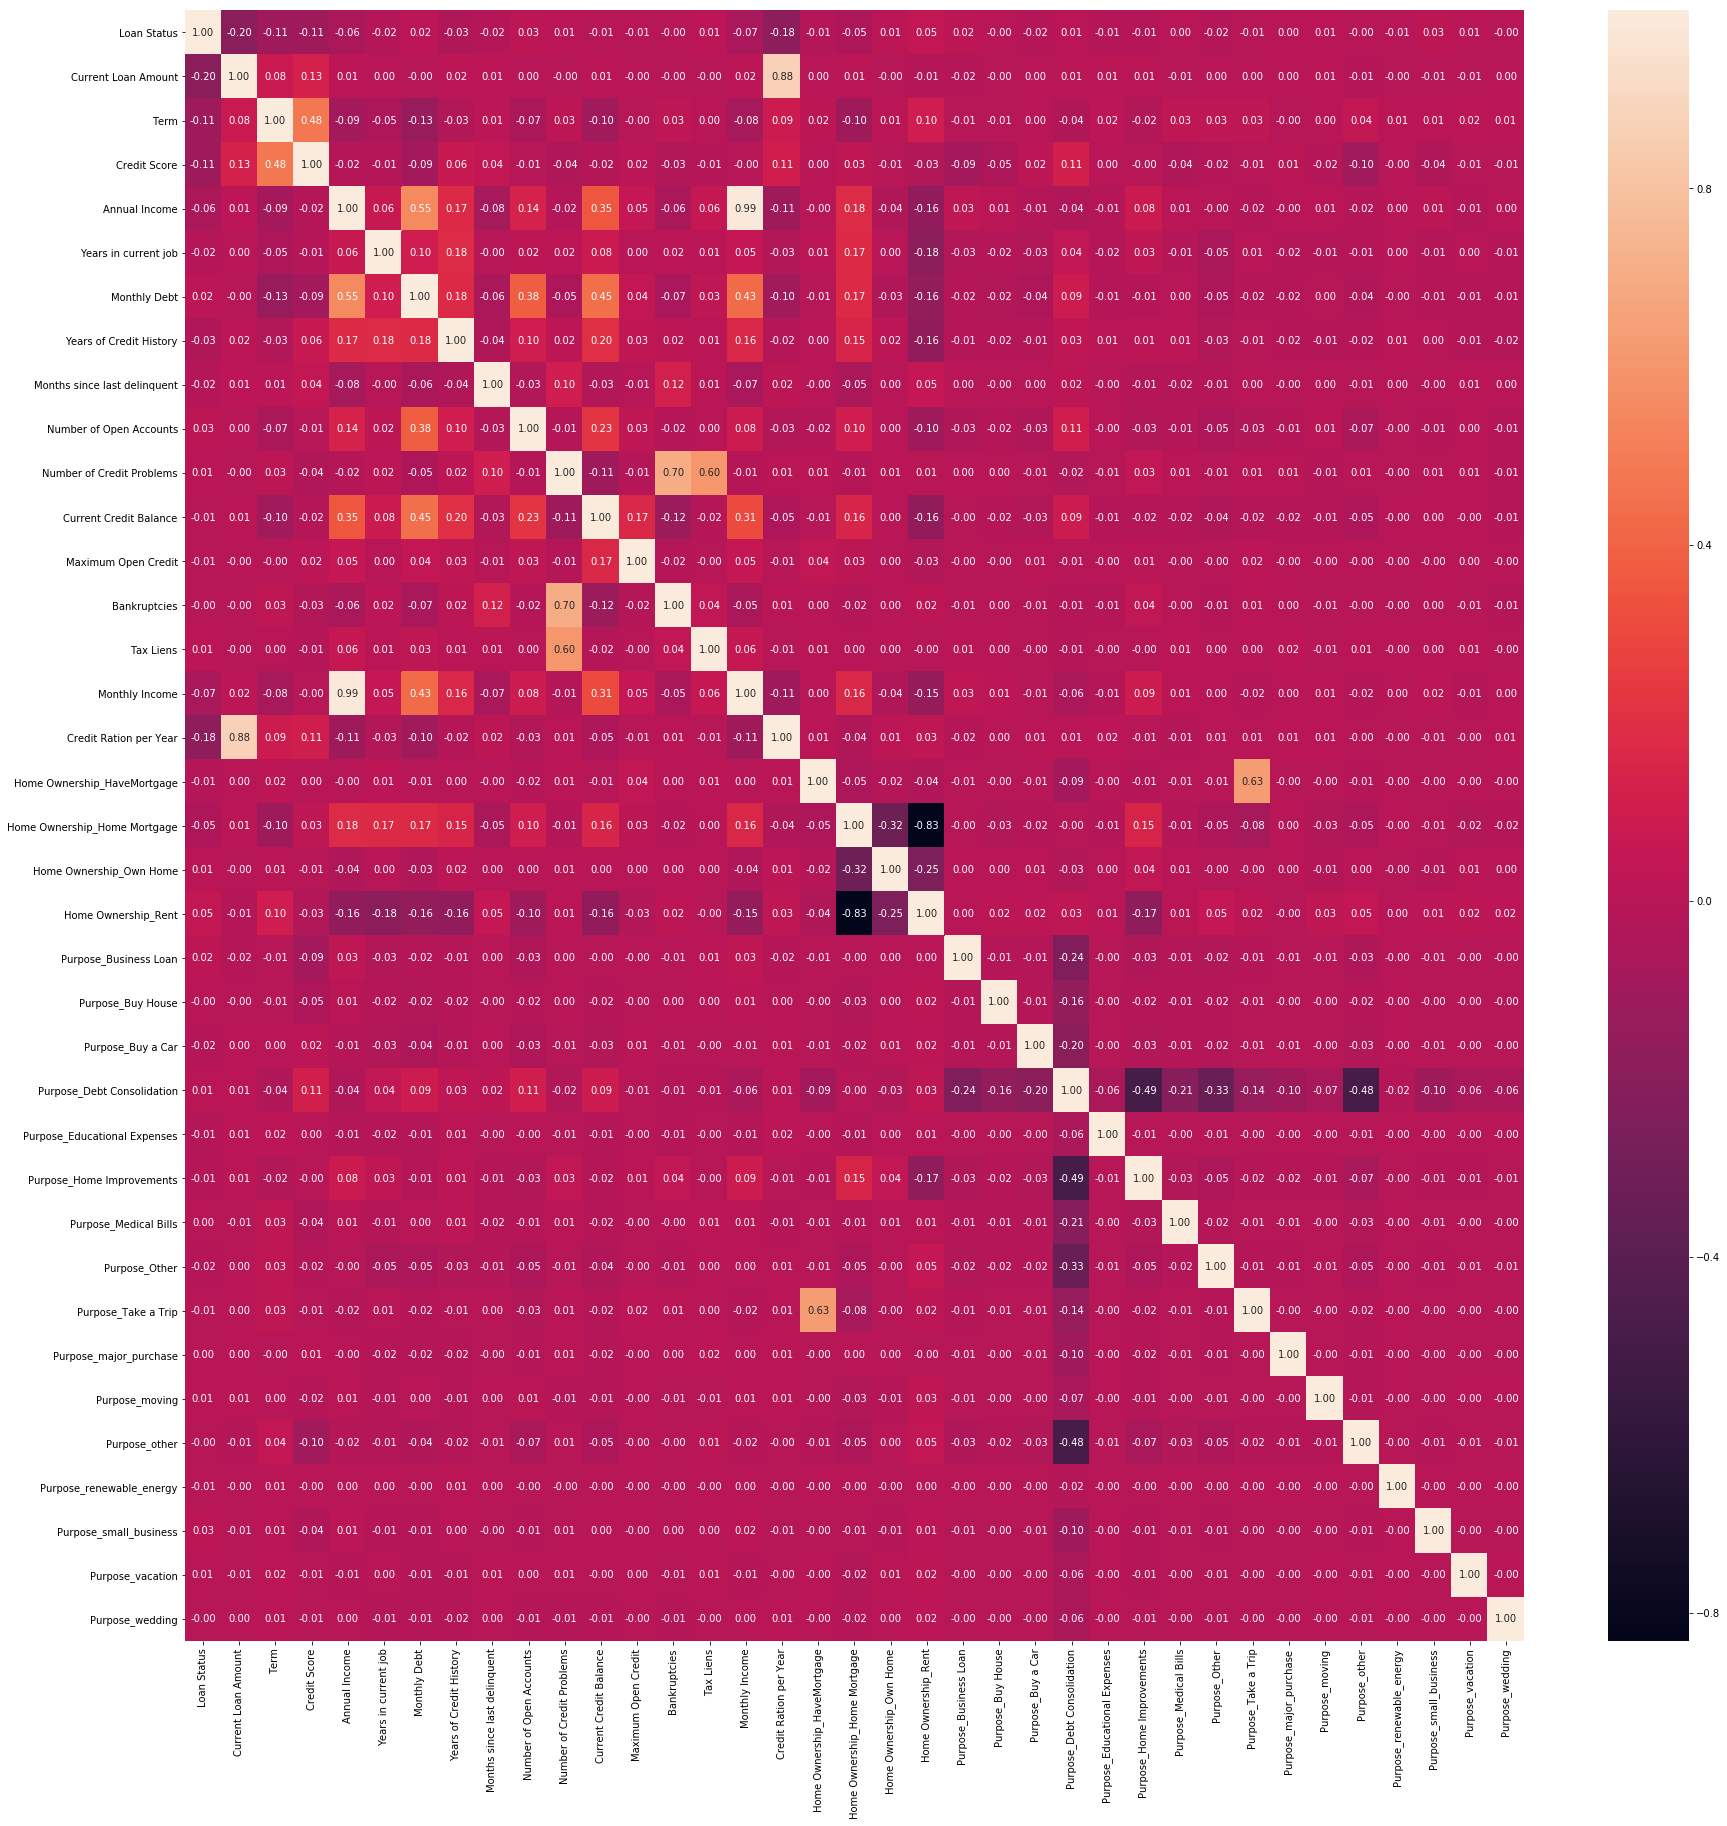

In [12]:
# show correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [13]:
#save as processed 
df.to_csv(data_folder + "/" + dataset + "_processed" + file_type)

## Basic cleaning
*(remove outliers)*

In [14]:
#Decide which categorical variables you want to use in model

for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature {0} has {1} unique categories".format(col_name, unique_cat))
df.info()

Feature Loan Status has 2 unique categories
Feature Current Loan Amount has 13914 unique categories
Feature Term has 2 unique categories
Feature Credit Score has 167 unique categories
Feature Annual Income has 20645 unique categories
Feature Years in current job has 11 unique categories
Feature Monthly Debt has 27103 unique categories
Feature Years of Credit History has 452 unique categories
Feature Months since last delinquent has 108 unique categories
Feature Number of Open Accounts has 46 unique categories
Feature Number of Credit Problems has 11 unique categories
Feature Current Credit Balance has 18486 unique categories
Feature Maximum Open Credit has 22109 unique categories
Feature Bankruptcies has 8 unique categories
Feature Tax Liens has 10 unique categories
Feature Monthly Income has 29269 unique categories
Feature Credit Ration per Year has 27196 unique categories
Feature Home Ownership_HaveMortgage has 2 unique categories
Feature Home Ownership_Home Mortgage has 2 unique cat

In [15]:
from sklearn.neighbors.kde import KernelDensity
def kde_sklearn(x, bandwidth=0.15, **kwargs):
    x_grid = np.linspace(x.min() - 1, x.max() + 1, 500)
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf), x_grid

In [16]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 -q1
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    return outlier_indices

In [17]:
def detect_outlier(col):
    threshold=3
    mean = np.mean(col.values)
    std = np.std(col.values)
    
    outlier_indices = list(col.index[(np.abs((col - mean)/std) > threshold)])
    return outlier_indices

In [18]:
import itertools
outliers = []
best = 0
best_subset = []
cols = ["Term",
"Monthly Income",
"Credit Ration per Year"]
counter = 0
for L in range(0, len(cols)+1):
    combinations = itertools.combinations(cols, L)
    print(len(list(combinations)))
    for subset in itertools.combinations(cols, L):
        print(subset)
        outliers = []
        for col_name in df.columns:
            if col_name in subset:
                outliers.append(detect_outlier(df[col_name]))
                outliers.append(find_outliers_tukey(df[col_name]))
        outliers_list = list(itertools.chain.from_iterable(outliers))
        outliers_list = list(dict.fromkeys(outliers_list))
        print("Dataset contains {0} outliers in run {1}".format(len(outliers_list), counter+1))
        df_temp = df.drop(outliers_list)
        corr_abs = abs(df_temp.corr())
        sum = corr_abs["Loan Status"].sum(skipna=True)
        if sum > best:
            best = sum
            best_subset = subset
        counter += 1
        

1
()
Dataset contains 0 outliers in run 1
3
('Term',)
Dataset contains 0 outliers in run 2
('Monthly Income',)
Dataset contains 1810 outliers in run 3
('Credit Ration per Year',)
Dataset contains 4923 outliers in run 4
3
('Term', 'Monthly Income')
Dataset contains 1810 outliers in run 5
('Term', 'Credit Ration per Year')
Dataset contains 4923 outliers in run 6
('Monthly Income', 'Credit Ration per Year')
Dataset contains 6471 outliers in run 7
1
('Term', 'Monthly Income', 'Credit Ration per Year')
Dataset contains 6471 outliers in run 8


In [19]:
best_outliers = []
for col_name in df.columns:
    if col_name in best_subset:
        best_outliers.append(detect_outlier(df[col_name]))
        best_outliers.append(find_outliers_tukey(df[col_name]))

In [24]:
outliers_list = list(itertools.chain.from_iterable(best_outliers))
outliers_list = list(dict.fromkeys(outliers_list))
print("Dataset contains {0} outliers".format(len(outliers_list)))

Dataset contains 1810 outliers


In [21]:
pdf, grid = kde_sklearn(np.asarray(outliers_list))

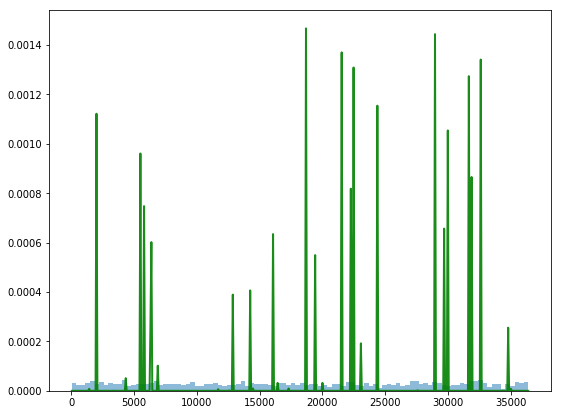

In [23]:
fig, ax2 = plt.subplots(figsize = (9,7))

#Plot histogram
ax2.hist(outliers_list, bins = 100, alpha = 0.5, density = True)
ax2.plot(grid, pdf, alpha = 0.9, color = 'green', linewidth = 2.0)
plt.show()

In [ ]:
df = df.drop(best_outliers)

In [ ]:
# Take a look at the outcome variable: Loan Status
print(df['Loan Status'].value_counts())

In [ ]:
# Distribution of features : Histograms broken up by outcome categories (in this case Loan Status)
def plot_histogram(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Fully Paid')
    plt.hist(list(x[y==1]), alpha=0.5, label='Charged off')
    plt.title('Histogram of {0} by Loan Status category'.format(x.name))
    plt.xlabel("value")
    plt.ylabel("frequency")
    plt.legend(loc='upper right')
    plt.show()
    
for x in df.columns:
    plot_histogram(df[x],df["Loan Status"])

In [ ]:
#calculate absolute correlation
corr_abs = abs(df.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)

In [ ]:
corr_abs["Loan Status"].sum(skipna=True)

In [413]:
#save as processed 
df.to_csv(data_folder + "/" + dataset + "_processed__removeoutliers" + file_type)

In [421]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_Y = df["Loan Status"]
df_X = df.drop("Loan Status", axis=1)

# Standardizing the features
df_X = StandardScaler().fit_transform(df_X)

pca = PCA(n_components = None)
X_pca = pd.DataFrame(pca.fit_transform(df_X))

In [422]:
X_pca.head(10)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,2.210450,0.688620,-0.889128,2.826316,-1.640667,1.600377,0.749744,0.252986,0.682815,0.145382,...,1.650696,-0.069075,-0.111744,0.000043,-6.399783e-15,-2.248578e-15,1.781968e-15,-1.656367e-17,1.177223e-15,5.402012e-17
1,-1.340170,-1.407699,1.013116,1.128654,-0.704385,1.949466,0.036317,0.821043,0.933040,0.063792,...,-0.359321,-0.048360,0.169836,-0.041720,2.891701e-15,-4.715877e-18,6.430412e-16,2.071523e-15,-1.437055e-16,-2.871069e-16
2,-0.073532,0.241830,2.416770,3.855898,-1.622775,-0.001046,1.363218,-1.789659,-0.235040,-0.519686,...,-0.630201,-0.063216,0.400068,-0.141664,-1.278606e-14,-4.944890e-15,3.470415e-15,2.644336e-15,1.131631e-15,-1.575742e-16
3,1.565192,0.251291,0.050442,-1.186107,0.315215,0.490348,-0.197451,0.477915,0.321592,0.785215,...,1.125772,0.034509,-0.089080,-0.146964,-4.902685e-14,1.137223e-15,-6.616612e-15,-2.146201e-14,-3.929681e-15,3.874031e-15
4,1.724582,-2.666982,0.756326,2.519605,-0.737729,0.270021,0.308703,-0.818437,0.475993,-0.220289,...,0.270701,-0.039006,0.521438,-0.304123,7.632307e-15,1.727954e-15,-1.275697e-15,4.609560e-16,-1.541734e-15,-1.647329e-19
5,2.817105,1.076342,0.519450,1.044381,-0.706640,1.468715,-0.653811,0.108258,-1.916672,-0.400453,...,-1.021042,0.046341,0.790332,0.340232,7.323685e-15,8.070744e-16,7.355961e-16,1.668635e-15,2.495318e-16,-4.737486e-16
6,-0.005109,-0.240549,-0.389967,-1.434536,0.345498,0.038627,-0.255374,-1.041842,-0.939857,0.176261,...,-0.123014,0.050963,-0.001547,-0.027066,7.191296e-16,1.355426e-16,2.963051e-16,4.700711e-16,-2.340521e-17,-5.351943e-17
7,-0.917164,-3.090900,1.315089,0.852900,0.260732,0.118101,-0.857481,1.010793,0.545968,0.201477,...,0.071779,-0.102255,-0.036410,0.525248,-4.023936e-15,-7.225241e-16,2.495259e-16,4.928071e-16,-4.397202e-16,5.801564e-17
8,1.353785,2.055345,-1.145302,-0.996742,-0.147069,1.006294,-0.248925,0.266916,-0.645273,0.066277,...,-0.586852,0.041846,0.664555,0.317702,-3.172860e-15,-6.533204e-16,6.898436e-16,3.646848e-16,3.769927e-16,1.707551e-16
9,-0.908156,2.076771,-2.269426,1.105674,-1.604137,2.090257,0.960341,-0.356566,0.059662,-0.204648,...,-0.103625,-0.038858,-0.200394,0.573802,-4.662273e-14,2.788065e-14,3.197006e-14,-1.437095e-14,-6.009600e-15,-3.717314e-15


In [416]:
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21427 entries, 0 to 21426
Data columns (total 37 columns):
0     21427 non-null float64
1     21427 non-null float64
2     21427 non-null float64
3     21427 non-null float64
4     21427 non-null float64
5     21427 non-null float64
6     21427 non-null float64
7     21427 non-null float64
8     21427 non-null float64
9     21427 non-null float64
10    21427 non-null float64
11    21427 non-null float64
12    21427 non-null float64
13    21427 non-null float64
14    21427 non-null float64
15    21427 non-null float64
16    21427 non-null float64
17    21427 non-null float64
18    21427 non-null float64
19    21427 non-null float64
20    21427 non-null float64
21    21427 non-null float64
22    21427 non-null float64
23    21427 non-null float64
24    21427 non-null float64
25    21427 non-null float64
26    21427 non-null float64
27    21427 non-null float64
28    21427 non-null float64
29    21427 non-null float64
30    21427 non-null 